# Final Project Submission
* Student name: James M. Irivng, Ph.D.
* Student pace: full time
* Scheduled project review date/time: 05/15/19 2:30 pm
* Instructor name: Jeff Herman / Brandon Lewis
* Blog post URL:


# Iowa Prisoner Recidivism

<img src="images/LSA_map_with_counties_districts_and_B54A5BBCE4156.jpg" width=80%>

## Data Source: Iowa Department of Corrections 

- Source: https://www.kaggle.com/slonnadube/recidivism-for-offenders-released-from-prison
- **Statistics about recidivism in prisoners from a 3 year prisoner**
- **Target:**
    - Recidivism - Return to Prison
- **Features:**
    - Fiscal Year Released
    - Recidivism Reporting Year
    - Race - Ethnicity
    - Age At Release
    - Convicting Offense Classification
    - Convicting Offense Type
    - Convicting Offense Subtype
    - Main Supervising District
    - Release Type
    - Release type: Paroled to Detainder united
    - Part of Target Population

### Detailed variable descriptions:

- **Fiscal Year Released**
    - Fiscal year (year ending June 30) for which the offender was released from prison.

- **Recidivism Reporting Year**
    - Fiscal year (year ending June 30) that marks the end of the 3-year tracking period. For example, offenders exited prison in FY 2012 are found in recidivism reporting year FY 2015.

- **Race - Ethnicity**
    - Offender's Race and Ethnicity

- **Convicting Offense Classification**
    - Maximum penalties: A Felony = Life; B Felony = 25 or 50 years; C Felony = 10 years; D Felony = 5 years; Aggravated Misdemeanor = 2 years; Serious Misdemeanor = 1 year; Simple Misdemeanor = 30 days

- **Convicting Offense Type**
    - General category for the most serious offense for which the offender was placed in prison.

- **Convicting Offense Subtype**
    - Further classification of the most serious offense for which the offender was placed in prison.

- **Release Type**
    - Reasoning for Offender's release from prison.

- **Main Supervising District**
    - The Judicial District supervising the offender for the longest time during the tracking period.

- **Recidivism - Return to Prison**
    - No = No Recidivism; Yes = Prison admission for any reason within the 3-year tracking period
    
- **Part of Target Population** 
    - The Department of Corrections has undertaken specific strategies to reduce recidivism rates for prisoners who are on parole and are part of the target population.
    ___

# USING THE OSEMN MODEL TO GUIDE WORKFLOW

1. **OBTAIN:**
    - [x] Import data, inspect, check for datatypes to convert and null values
<br><br>

2. **SCRUB: cast data types, identify outliers, check for multicollinearity, normalize data**<br>
    - Check and cast data types
    - [x] Check for missing values 
    - [x] Check for multicollinearity
    - [x] Normalize data (may want to do after some exploring)   
    <br><br>
            
3. **EXPLORE:Check distributions, outliers, etc**
    - [x] Check scales, ranges (df.describe())
    - [x] Check histograms to get an idea of distributions (df.hist()) and data transformations to perform
    - [x] Use scatterplots to check for linearity and possible categorical variables (df.plot(kind-'scatter')
    <br><br>

   
4. **FIT AN INITIAL MODEL:** 
    - [x] Assess the model.
        <br><br>
5. **REVISE THE FITTED MODEL**
    - [x] Adjust chosen model and hyper-parameters
    <br><br>
6. **HOLDOUT VALIDATION**
    - [ ] Perform cross-validation
___

# OBTAIN:

### Using Custom PyPi Package - `fsds`


In [1]:
import bs_ds_local as bs

In [2]:
# !pip install -U fsds
from fsds.imports import *

fsds v0.2.25 loaded.  Read the docs: https://fs-ds.readthedocs.io/en/latest/ 


Handle,Package,Description
dp,IPython.display,Display modules with helpful display and clearing commands.
fs,fsds,Custom data science bootcamp student package
mpl,matplotlib,Matplotlib's base OOP module with formatting artists
plt,matplotlib.pyplot,Matplotlib's matlab-like plotting module
np,numpy,scientific computing with Python
pd,pandas,High performance data structures and tools
sns,seaborn,High-level data visualization library based on matplotlib


[i] Pandas .iplot() method activated.


In [3]:
## Set Pandas Options
pd_options = {
    'display.max_rows'    : 200,
    'display.max_info_rows':200,
    'display.max_columns' : 0,
#     'display.float_format':'${:,.2f}'.format
}
[pd.set_option(option, setting) for option, setting in pd_options.items()]


## Set Plot Style
plt.style.use('dark_background')

## Suppress Warnings
import warnings
warnings.filterwarnings

<function warnings.filterwarnings(action, message='', category=<class 'Warning'>, module='', lineno=0, append=False)>

In [4]:
import bs_ds_local as bs

## Loading the dataset and removing unrelated columns

In [5]:
ls data/

3-Year_Recidivism_for_Offenders_Released_from_Prison_in_Iowa.csv
Iowa_recidivism_features_cleaned_2020.csv
iowa_recidivism_renamed_2020.csv


In [6]:
df = pd.read_csv('data/3-Year_Recidivism_for_Offenders_Released_from_Prison_in_Iowa.csv')
df

,Fiscal Year Released,Recidivism Reporting Year,Main Supervising District,Release Type,Race - Ethnicity,Age At Release,Sex,Offense Classification,Offense Type,Offense Subtype,Return to Prison,Days to Return,Recidivism Type,New Offense Classification,New Offense Type,New Offense Sub Type,Target Population
0,2010,2013,7JD,Parole,Black - Non-Hispanic,25-34,Male,C Felony,Violent,Robbery,Yes,433.0,New,C Felony,Drug,Trafficking,Yes
1,2010,2013,NaN,Discharged – End of Sentence,White - Non-Hispanic,25-34,Male,D Felony,Property,Theft,Yes,453.0,Tech,NaN,NaN,NaN,No
2,2010,2013,5JD,Parole,White - Non-Hispanic,35-44,Male,B Felony,Drug,Trafficking,Yes,832.0,Tech,NaN,NaN,NaN,Yes
3,2010,2013,6JD,Parole,White - Non-Hispanic,25-34,Male,B Felony,Other,Other Criminal,No,NaN,No Recidivism,NaN,NaN,NaN,Yes
4,2010,2013,NaN,Discharged – End of Sentence,Black - Non-Hispanic,35-44,Male,D Felony,Violent,Assault,Yes,116.0,Tech,NaN,NaN,NaN,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26015,2015,2018,NaN,Paroled to Detainer - INS,White - Hispanic,Under 25,Male,C Felony,Violent,Assault,No,NaN,No Recidivism,NaN,NaN,NaN,Yes
26016,2015,2018,6JD,Released to Special Sentence,White - Non-Hispanic,35-44,Male,C Felony,Violent,Sex,No,NaN,No Recidivism,NaN,NaN,NaN,No
26017,2015,2018,5JD,Parole Granted,White - Non-Hispanic,25-34,Female,Aggravated Misdemeanor,Public Order,Traffic,No,NaN,No Recidivism,NaN,NaN,NaN,No
26018,2015,2018,5JD,Paroled w/Immediate Discharge,White - Non-Hispanic,25-34,Male,D Felony,Property,Theft,No,NaN,No Recidivism,NaN,NaN,NaN,Yes


**Any columns that are about New Convictions or days to recidivism should be dropped for our initial model predicting recidivism.**
- "New..", "Days to Recividism"

In [7]:
## Drop cols related to recivism details 
drop_expr = ['New',"Days","Recidivism Type","Year"]

drop_cols = []
for exp in drop_expr:
    drop_cols.extend([col for col in df.columns if exp in col])
    
df.drop(columns=drop_cols,inplace=True)
df.head()

,Main Supervising District,Release Type,Race - Ethnicity,Age At Release,Sex,Offense Classification,Offense Type,Offense Subtype,Return to Prison,Target Population
0,7JD,Parole,Black - Non-Hispanic,25-34,Male,C Felony,Violent,Robbery,Yes,Yes
1,NaN,Discharged – End of Sentence,White - Non-Hispanic,25-34,Male,D Felony,Property,Theft,Yes,No
2,5JD,Parole,White - Non-Hispanic,35-44,Male,B Felony,Drug,Trafficking,Yes,Yes
3,6JD,Parole,White - Non-Hispanic,25-34,Male,B Felony,Other,Other Criminal,No,Yes
4,NaN,Discharged – End of Sentence,Black - Non-Hispanic,35-44,Male,D Felony,Violent,Assault,Yes,No


### Save original names vs short names in column_legend
- then map names onto columns

In [8]:
## Replacing columns with short names
rename_map = {
    'Fiscal Year Released': 'yr_released',
    'Recidivism Reporting Year': 'report_year' ,
    'Main Supervising District': 'supervising_dist' ,
    'Release Type': 'release_type' ,
    'Race - Ethnicity': 'race_ethnicity'  ,
    'Age At Release ':  'age_released' ,
    'Sex':'sex'   ,
    'Offense Classification': 'crime_class' ,
    'Offense Type': 'crime_type'  ,
    'Offense Subtype':  'crime_subtype' ,
    'Return to Prison': 'recidivist'  ,
    'Target Population':  'target_pop'
}

df = df.rename(rename_map,axis=1)
df

,supervising_dist,release_type,race_ethnicity,age_released,sex,crime_class,crime_type,crime_subtype,recidivist,target_pop
0,7JD,Parole,Black - Non-Hispanic,25-34,Male,C Felony,Violent,Robbery,Yes,Yes
1,NaN,Discharged – End of Sentence,White - Non-Hispanic,25-34,Male,D Felony,Property,Theft,Yes,No
2,5JD,Parole,White - Non-Hispanic,35-44,Male,B Felony,Drug,Trafficking,Yes,Yes
3,6JD,Parole,White - Non-Hispanic,25-34,Male,B Felony,Other,Other Criminal,No,Yes
4,NaN,Discharged – End of Sentence,Black - Non-Hispanic,35-44,Male,D Felony,Violent,Assault,Yes,No
...,...,...,...,...,...,...,...,...,...,...
26015,NaN,Paroled to Detainer - INS,White - Hispanic,Under 25,Male,C Felony,Violent,Assault,No,Yes
26016,6JD,Released to Special Sentence,White - Non-Hispanic,35-44,Male,C Felony,Violent,Sex,No,No
26017,5JD,Parole Granted,White - Non-Hispanic,25-34,Female,Aggravated Misdemeanor,Public Order,Traffic,No,No
26018,5JD,Paroled w/Immediate Discharge,White - Non-Hispanic,25-34,Male,D Felony,Property,Theft,No,Yes


In [9]:
df.to_csv('data/iowa_recidivism_renamed_2020.csv')

# SCRUB / EXPLORE


In [10]:
## Explore Dtypes and info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26020 entries, 0 to 26019
Data columns (total 10 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   supervising_dist  object
 1   release_type      object
 2   race_ethnicity    object
 3   age_released      object
 4   sex               object
 5   crime_class       object
 6   crime_type        object
 7   crime_subtype     object
 8   recidivist        object
 9   target_pop        object
dtypes: object(10)
memory usage: 2.0+ MB


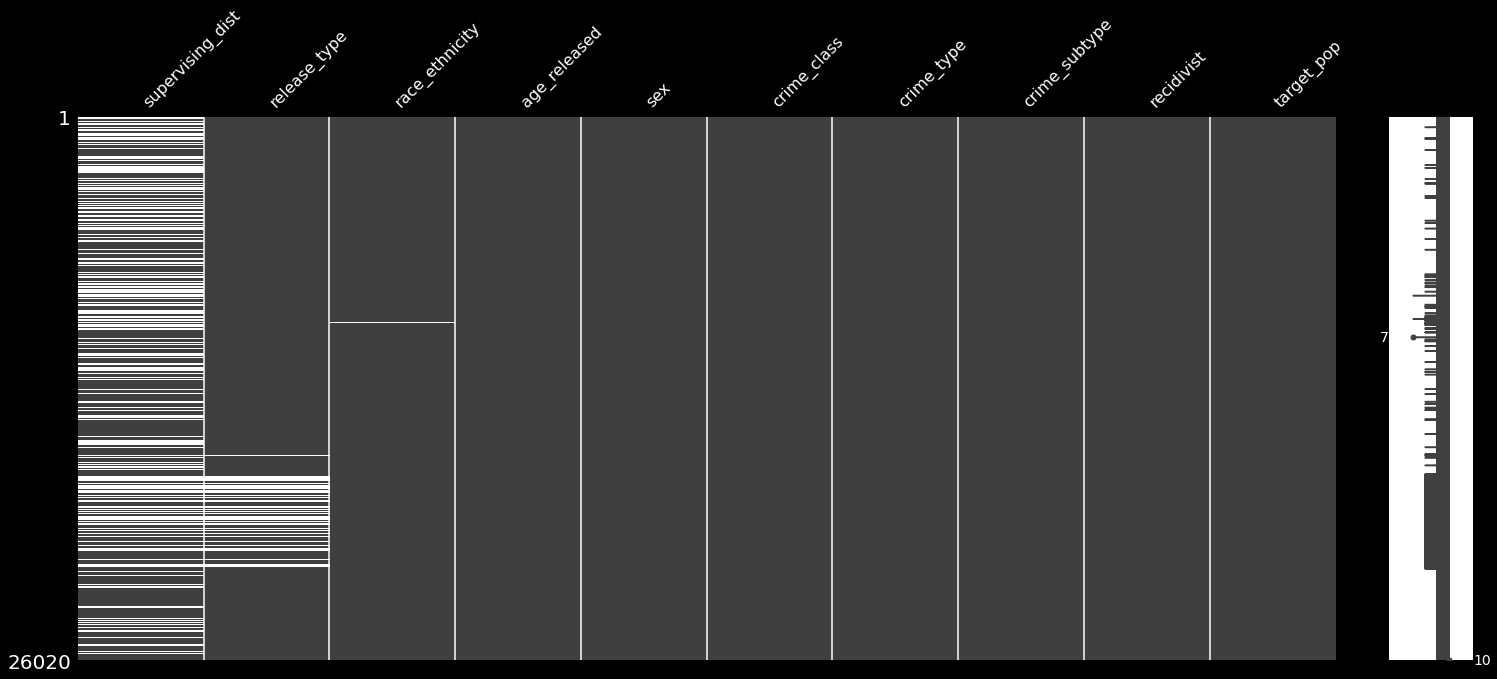

,#,%
supervising_dist,9581,36.820000
release_type,1762,6.770000
race_ethnicity,30,0.120000
age_released,3,0.010000
sex,3,0.010000


In [11]:
import missingno as ms


def nulls_report(df):
    nulls= df.isna().sum()
    nulls_only = nulls[nulls>0].to_frame('#')
    nulls_only['%'] = ((nulls_only['#']/len(df))*100)
    nulls_only = nulls_only.round(2)
    capt='Columns with Null Values:'
    display(nulls_only.style.set_caption(capt))
ms.matrix(df)
plt.show()
  
    
nulls_report(df)


**Results of Null Check**
- race_ethnicity has 30 (0.12% of data)
    -  drop
- age_released has 3 (0.01% of data)
    - drop
- sex has 3 (0.01% of data)
    - drop
- super_district has 9581(36.82% of data)
    - replace with "unknown"
- release_type has 1762 (6.77% of data)
    - drop
    
**Dropping all null values from age_released, race_ethnicity, and release_type.**

## SIMPLIFYING CATEGORICAL FEATURES

### Making `age_released` numerical

In [12]:
def value_counts(col,dropna=False,normalize=True):
    """Convenience function for display value counts with default params"""
    return col.value_counts(dropna=dropna,normalize=normalize)

In [13]:
value_counts(df['age_released'])#.value_counts(dropna=False)

25-34           0.367179
35-44           0.239162
Under 25        0.176403
45-54           0.167064
55 and Older    0.050077
NaN             0.000115
Name: age_released, dtype: float64

In [14]:
# Mapping age_map onto 'age_released'
# Encoding age groups as ordinal
age_ranges = ('Under 25','25-34', '35-44','45-54','55 and Older')
age_numbers = (20,30,40,50,70) 
age_num_map = dict(zip(age_ranges,age_numbers))
age_num_map

{'Under 25': 20, '25-34': 30, '35-44': 40, '45-54': 50, '55 and Older': 70}

In [15]:
df['age_released'] = df['age_released'].map(age_num_map)
value_counts(df['age_released'])

30.0    0.367179
40.0    0.239162
20.0    0.176403
50.0    0.167064
70.0    0.050077
NaN     0.000115
Name: age_released, dtype: float64

### df['race_ethnicity']

In [16]:
value_counts(df['race_ethnicity'])

White - Non-Hispanic                               0.675788
Black - Non-Hispanic                               0.234781
White - Hispanic                                   0.058493
American Indian or Alaska Native - Non-Hispanic    0.019293
Asian or Pacific Islander - Non-Hispanic           0.007379
Black - Hispanic                                   0.001422
NaN                                                0.001153
American Indian or Alaska Native - Hispanic        0.000769
White -                                            0.000461
N/A -                                              0.000192
Asian or Pacific Islander - Hispanic               0.000192
Black -                                            0.000077
Name: race_ethnicity, dtype: float64

- **Remapping race_ethnicity**
    - Due to the low numbers for several of the race_ethnicity types, reducing and combining Hispanic and Non-Hispanic groups
    - Alternative approach of separating race and ethnicity into 2 separate features was rejected after modeling

In [17]:
# Defining Dictionary Map for race_ethnicity categories
race_ethnicity_map = {'White - Non-Hispanic':'White',
                        'Black - Non-Hispanic': 'Black',
                        'White - Hispanic' : 'Hispanic',
                        'American Indian or Alaska Native - Non-Hispanic' : 'American Native',
                        'Asian or Pacific Islander - Non-Hispanic' : 'Asian or Pacific Islander',
                        'Black - Hispanic' : 'Black',
                        'American Indian or Alaska Native - Hispanic':'American Native',
                        'White -' : 'White',
                        'Asian or Pacific Islander - Hispanic' : 'Asian or Pacific Islander',
                        'N/A -' : np.nan,
                        'Black -':'Black'}

# Replacing original race_ethnicity column with remapped one.
df['race_ethnicity'] = df['race_ethnicity'].map(race_ethnicity_map)
value_counts(df['race_ethnicity'])

White                        0.676249
Black                        0.236280
Hispanic                     0.058493
American Native              0.020061
Asian or Pacific Islander    0.007571
NaN                          0.001345
Name: race_ethnicity, dtype: float64

### df['crime_class']

- **Remapping crime_class**
    - Combine 'Other Felony' and 'Other Felony (Old Code)' -> nan
    - Other Misdemeanor -> np.nan
    - Felony - Mandatory Minimum -> np.nan
    - Special Sentence 2005 -> Sex Offender
    - 'Sexual Predator Community Supervision' -> 'Sex Offender'
    - Other Felony -> np.nan    

In [18]:
value_counts(df['crime_class'])

D Felony                                    0.403036
C Felony                                    0.261453
Aggravated Misdemeanor                      0.189470
B Felony                                    0.067832
Felony - Enhancement to Original Penalty    0.058916
Felony - Enhanced                           0.008455
Serious Misdemeanor                         0.005957
Special Sentence 2005                       0.003766
Felony - Mandatory Minimum                  0.000423
Other Felony                                0.000231
A Felony                                    0.000154
Simple Misdemeanor                          0.000115
Other Felony (Old Code)                     0.000077
Sexual Predator Community Supervision       0.000077
Other Misdemeanor                           0.000038
Name: crime_class, dtype: float64

In [19]:
# Remapping
crime_class_map = {'Other Felony (Old Code)':'Other Felony' ,#or other felony
                  'Other Misdemeanor':'Other Misdemeanor',
                   'Felony - Mandatory Minimum':'Other Felony',#np.nan, # if minimum then lowest sentence ==  D Felony
                   'Special Sentence 2005': 'Sex Offender',
                   'Other Felony' : 'Other Felony' ,
                   'Sexual Predator Community Supervision' : 'Sex Offender',
                   'D Felony': 'D Felony',
                   'C Felony' :'C Felony',
                   'B Felony' : 'B Felony',
                   'A Felony' : 'A Felony',
                   'Aggravated Misdemeanor':'Aggravated Misdemeanor',
                   'Felony - Enhancement to Original Penalty':'Felony - Enhanced',
                   'Felony - Enhanced':'Felony - Enhanced' ,
                   'Serious Misdemeanor':'Serious Misdemeanor',
                   'Simple Misdemeanor':'Simple Misdemeanor'}

df['crime_class'] = df['crime_class'].map(crime_class_map)
value_counts(df['crime_class'])

D Felony                  0.403036
C Felony                  0.261453
Aggravated Misdemeanor    0.189470
B Felony                  0.067832
Felony - Enhanced         0.067371
Serious Misdemeanor       0.005957
Sex Offender              0.003843
Other Felony              0.000730
A Felony                  0.000154
Simple Misdemeanor        0.000115
Other Misdemeanor         0.000038
Name: crime_class, dtype: float64

### Remapping target

In [20]:
# Recidivist
df['recidivist'] = df['recidivist'].map( {'No':0,'Yes':1})
value_counts(df['recidivist'])

0    0.666372
1    0.333628
Name: recidivist, dtype: float64

In [21]:
df.head()

,supervising_dist,release_type,race_ethnicity,age_released,sex,crime_class,crime_type,crime_subtype,recidivist,target_pop
0,7JD,Parole,Black,30.0,Male,C Felony,Violent,Robbery,1,Yes
1,NaN,Discharged – End of Sentence,White,30.0,Male,D Felony,Property,Theft,1,No
2,5JD,Parole,White,40.0,Male,B Felony,Drug,Trafficking,1,Yes
3,6JD,Parole,White,30.0,Male,B Felony,Other,Other Criminal,0,Yes
4,NaN,Discharged – End of Sentence,Black,40.0,Male,D Felony,Violent,Assault,1,No


___
## FEATURE ENGINEERING
- **Engineering a simple 'felony' true false category**
- **Combining crime_type and crime_subtype into types_combined**

### Creating a simple 'felony' feature

In [22]:
# Engineering a simple 'felony' true false category
df['felony'] = df['crime_class'].str.contains('felony',case=False)
value_counts(df['felony'])

True     0.800576
False    0.199424
Name: felony, dtype: float64

In [23]:
# df['crime_types_combined'] = df['crime_type']+'_'+df['crime_subtype']
# value_counts(df['crime_types_combined'])

In [24]:
# Combining crime_type and crime_subtype into types_combined
# df['crime_class_type_subtype']= df['crime_class']+'_'+df['crime_type']+'_'+df['crime_subtype']
# value_counts(df['crime_class_type_subtype'])
df.nunique()

supervising_dist    10
release_type        12
race_ethnicity       5
age_released         5
sex                  2
crime_class         11
crime_type           5
crime_subtype       26
recidivist           2
target_pop           2
felony               2
dtype: int64

### Creating a 'max_sentence' feature based on crime class max penalties
   

In [25]:
# Mapping years onto crime class
crime_class_max_sentence_map = {'A Felony': 75,  # Life
                                'Aggravated Misdemeanor': 2, # 2 years
                                'B Felony': 50, # 25 or 50 years
                                'C Felony': 10, # 10 years
                                'D Felony': 5,  # 5 yeras
                                'Felony - Enhanced': 10, # Add on to class C and D felonies, hard to approximate. 
                                'Serious Misdemeanor': 1, # 1 year
                                'Sex Offender': 10, # 10 years
                                'Simple Misdemeanor': 0.83} # 30 days

# Mapping max_sentence_column
df['max_sentence'] =df['crime_class'].map(crime_class_max_sentence_map)
value_counts(df['max_sentence'])

5.00     0.403036
10.00    0.332667
2.00     0.189470
50.00    0.067832
1.00     0.005957
NaN      0.000769
75.00    0.000154
0.83     0.000115
Name: max_sentence, dtype: float64

### Dropping all  values replaced with np.nan

In [26]:
nulls_report(df)

,#,%
supervising_dist,9581,36.820000
release_type,1762,6.770000
race_ethnicity,35,0.130000
age_released,3,0.010000
sex,3,0.010000
max_sentence,20,0.080000


## Checking Final Dtypes

In [27]:
df.info()
dtypes = {'yr_released':str,
         'report_year':str}

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26020 entries, 0 to 26019
Data columns (total 12 columns):
 #   Column            Dtype  
---  ------            -----  
 0   supervising_dist  object 
 1   release_type      object 
 2   race_ethnicity    object 
 3   age_released      float64
 4   sex               object 
 5   crime_class       object 
 6   crime_type        object 
 7   crime_subtype     object 
 8   recidivist        int64  
 9   target_pop        object 
 10  felony            bool   
 11  max_sentence      float64
dtypes: bool(1), float64(2), int64(1), object(8)
memory usage: 2.2+ MB


# BOOKMARK

## Preprocessing with  Pipelines and ColumnTransformer

In [28]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler,OneHotEncoder

from sklearn.model_selection import train_test_split

In [29]:
from sklearn import set_config
set_config(display='text')

In [30]:
## Make x and y
target = 'recidivist'
X = df.drop(columns=target).copy()
y = df[target].copy()
value_counts(y)

0    0.666372
1    0.333628
Name: recidivist, dtype: float64

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y)

## BOOKMARK 

In [32]:
## Get a list of columns to be run as numeric data
num_cols = X_train.select_dtypes('number').columns
num_cols

Index(['age_released', 'max_sentence'], dtype='object')

In [33]:
nulls_report(df)

,#,%
supervising_dist,9581,36.820000
release_type,1762,6.770000
race_ethnicity,35,0.130000
age_released,3,0.010000
sex,3,0.010000
max_sentence,20,0.080000


In [34]:
## Make a num_transformer pipeline
set_config(display='diagram')
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler',StandardScaler())])
num_transformer

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())])

In [35]:
# ## vis as diagram
# set_config(display='text')
# num_transformer

In [36]:
## Get a list of columns to be run as categorical data
cat_cols = X_train.select_dtypes('O').columns
cat_cols

Index(['supervising_dist', 'release_type', 'race_ethnicity', 'sex',
       'crime_class', 'crime_type', 'crime_subtype', 'target_pop'],
      dtype='object')

In [37]:
## Create a cat_transformer pipeline 
cat_transformer = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='constant',fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore',sparse=False))])#handle_unknown='ignore',
cat_transformer

## that will impute using median and then calculate z-scores


Pipeline(steps=[('imputer',
                 SimpleImputer(fill_value='missing', strategy='constant')),
                ('encoder',
                 OneHotEncoder(handle_unknown='ignore', sparse=False))])

In [38]:
# TO DO: make another cat encoder with drop='if_binary'drop='if_binary',

### Combine Preprocessing into one ColumnTransformer

In [39]:
## COMBINE BOTH PIPELINES INTO ONE WITH COLUMN TRANSFORMER
from sklearn.compose import ColumnTransformer
preprocessing = ColumnTransformer(transformers=[
    ('num',num_transformer,num_cols),
    ('cat',cat_transformer,cat_cols)])
preprocessing

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 Index(['age_released', 'max_sentence'], dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 Index(['supervising_dist', 'release_type', 'race_ethnicity', 'sex',
       'crime_class', 'crime_type', 'crime_subtype', 'target_pop'],
      dtype='object'))])

In [40]:
## Get X_train and X_test from column transformer
X_train_tf = preprocessing.fit_transform(X_train)
X_train_tf

array([[ 0.32094541,  0.08318531,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       [-0.48523938,  0.08318531,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       [-1.29142417,  3.60428813,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [-1.29142417, -0.35695254,  1.        , ...,  0.        ,
         0.        ,  1.        ],
       [-1.29142417,  0.08318531,  1.        , ...,  0.        ,
         0.        ,  1.        ],
       [ 0.32094541,  0.08318531,  1.        , ...,  0.        ,
         0.        ,  1.        ]])

> **One downside of Pipelines is that its harder to get the individual info we need to re-form our dataset as a df**

In [41]:
cat_features = preprocessing.named_transformers_['cat'].named_steps['encoder'].get_feature_names(cat_cols)
X_train_tf = pd.DataFrame(X_train_tf,columns=[*num_cols, *cat_features])
X_train_tf.head()

,age_released,max_sentence,supervising_dist_1JD,supervising_dist_2JD,supervising_dist_3JD,supervising_dist_4JD,supervising_dist_5JD,supervising_dist_6JD,supervising_dist_7JD,supervising_dist_8JD,supervising_dist_ISC,supervising_dist_Interstate Compact,supervising_dist_missing,release_type_Discharged - Expiration of Sentence,release_type_Discharged – End of Sentence,release_type_Parole,release_type_Parole Granted,release_type_Paroled to Detainer - INS,release_type_Paroled to Detainer - Iowa,release_type_Paroled to Detainer - Out of State,release_type_Paroled to Detainer - U.S. Marshall,release_type_Paroled w/Immediate Discharge,release_type_Released to Special Sentence,release_type_Special Sentence,release_type_missing,race_ethnicity_American Native,race_ethnicity_Asian or Pacific Islander,race_ethnicity_Black,race_ethnicity_Hispanic,race_ethnicity_White,race_ethnicity_missing,sex_Female,sex_Male,sex_missing,crime_class_A Felony,crime_class_Aggravated Misdemeanor,crime_class_B Felony,crime_class_C Felony,crime_class_D Felony,crime_class_Felony - Enhanced,crime_class_Other Felony,crime_class_Other Misdemeanor,crime_class_Serious Misdemeanor,crime_class_Sex Offender,crime_class_Simple Misdemeanor,crime_type_Drug,crime_type_Other,crime_type_Property,crime_type_Public Order,crime_type_Violent,crime_subtype_Alcohol,crime_subtype_Animals,crime_subtype_Arson,crime_subtype_Assault,crime_subtype_Burglary,crime_subtype_Drug Possession,crime_subtype_Flight/Escape,crime_subtype_Forgery/Fraud,crime_subtype_Kidnap,crime_subtype_Murder/Manslaughter,crime_subtype_OWI,crime_subtype_Other Criminal,crime_subtype_Other Drug,crime_subtype_Other Public Order,crime_subtype_Other Violent,crime_subtype_Prostitution/Pimping,crime_subtype_Robbery,crime_subtype_Sex,crime_subtype_Sex Offender Registry/Residency,crime_subtype_Special Sentence Revocation,crime_subtype_Stolen Property,crime_subtype_Theft,crime_subtype_Traffic,crime_subtype_Trafficking,crime_subtype_Vandalism,crime_subtype_Weapons,target_pop_No,target_pop_Yes
0,0.320945,0.083185,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,-0.485239,0.083185,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,-1.291424,3.604288,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-0.485239,-0.356953,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.320945,-0.356953,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [42]:
X_test_tf = pd.DataFrame( preprocessing.transform(X_test),
                         columns=[*num_cols, *cat_features])
X_test_tf.head()

,age_released,max_sentence,supervising_dist_1JD,supervising_dist_2JD,supervising_dist_3JD,supervising_dist_4JD,supervising_dist_5JD,supervising_dist_6JD,supervising_dist_7JD,supervising_dist_8JD,supervising_dist_ISC,supervising_dist_Interstate Compact,supervising_dist_missing,release_type_Discharged - Expiration of Sentence,release_type_Discharged – End of Sentence,release_type_Parole,release_type_Parole Granted,release_type_Paroled to Detainer - INS,release_type_Paroled to Detainer - Iowa,release_type_Paroled to Detainer - Out of State,release_type_Paroled to Detainer - U.S. Marshall,release_type_Paroled w/Immediate Discharge,release_type_Released to Special Sentence,release_type_Special Sentence,release_type_missing,race_ethnicity_American Native,race_ethnicity_Asian or Pacific Islander,race_ethnicity_Black,race_ethnicity_Hispanic,race_ethnicity_White,race_ethnicity_missing,sex_Female,sex_Male,sex_missing,crime_class_A Felony,crime_class_Aggravated Misdemeanor,crime_class_B Felony,crime_class_C Felony,crime_class_D Felony,crime_class_Felony - Enhanced,crime_class_Other Felony,crime_class_Other Misdemeanor,crime_class_Serious Misdemeanor,crime_class_Sex Offender,crime_class_Simple Misdemeanor,crime_type_Drug,crime_type_Other,crime_type_Property,crime_type_Public Order,crime_type_Violent,crime_subtype_Alcohol,crime_subtype_Animals,crime_subtype_Arson,crime_subtype_Assault,crime_subtype_Burglary,crime_subtype_Drug Possession,crime_subtype_Flight/Escape,crime_subtype_Forgery/Fraud,crime_subtype_Kidnap,crime_subtype_Murder/Manslaughter,crime_subtype_OWI,crime_subtype_Other Criminal,crime_subtype_Other Drug,crime_subtype_Other Public Order,crime_subtype_Other Violent,crime_subtype_Prostitution/Pimping,crime_subtype_Robbery,crime_subtype_Sex,crime_subtype_Sex Offender Registry/Residency,crime_subtype_Special Sentence Revocation,crime_subtype_Stolen Property,crime_subtype_Theft,crime_subtype_Traffic,crime_subtype_Trafficking,crime_subtype_Vandalism,crime_subtype_Weapons,target_pop_No,target_pop_Yes
0,-0.485239,-0.356953,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,-0.485239,-0.621035,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.127130,-0.621035,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-0.485239,-0.356953,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-0.485239,0.083185,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


# MODELING

In [43]:
import sklearn.metrics as metrics

def evaluate_classification(model,X_test,y_test,classes=['Non Recid','Recidivst'],
                           normalize='true',cmap='Purples',label='',
                           return_report=False):
    """Accepts an sklearn-compatible classification model + test data 
    and displays several sklearn.metrics functions: 
    - classifciation_report
    - plot_confusion_matrix
    - plot_roc_curve
    """
     
    ## Get Predictions
    y_hat_test = model.predict(X_test)
    
    ## Classification Report / Scores 
    table_header = "[i] CLASSIFICATION REPORT"
    
    ## Add Label if given
    if len(label)>0:
        table_header += f":\t{label}"
        
    
    ## PRINT CLASSIFICATION REPORT
    dashes = '---'*20
    print(dashes,table_header,dashes,sep='\n')

    print(metrics.classification_report(y_test,y_hat_test,
                                    target_names=classes))
    
    report = metrics.classification_report(y_test,y_hat_test,
                                               target_names=classes,
                                          output_dict=True)
    print(dashes+"\n\n")
    
    

    ## MAKE FIGURE
    fig, axes = plt.subplots(figsize=(10,4),ncols=2)
    
    ## Plot Confusion Matrix 
    metrics.plot_confusion_matrix(model, X_test,y_test,
                                  display_labels=classes,
                                  normalize=normalize,
                                 cmap=cmap,ax=axes[0])
    axes[0].set(title='Confusion Matrix')
    
    ## Plot Roc Curve
    roc_plot = metrics.plot_roc_curve(model, X_test, y_test,ax=axes[1])
    axes[1].legend()
    axes[1].plot([0,1],[0,1],ls=':')
    axes[1].grid()
    axes[1].set_title('Receiving Operator Characteristic (ROC) Curve') 
    fig.tight_layout()
    plt.show()
    
    if return_report:
        return report #fig,axes

## Baseline DummyClassifier

------------------------------------------------------------
[i] CLASSIFICATION REPORT:	Dummy Classifier
------------------------------------------------------------
              precision    recall  f1-score   support

   Non Recid       0.67      0.67      0.67      4335
   Recidivst       0.34      0.34      0.34      2170

    accuracy                           0.56      6505
   macro avg       0.51      0.51      0.51      6505
weighted avg       0.56      0.56      0.56      6505

------------------------------------------------------------




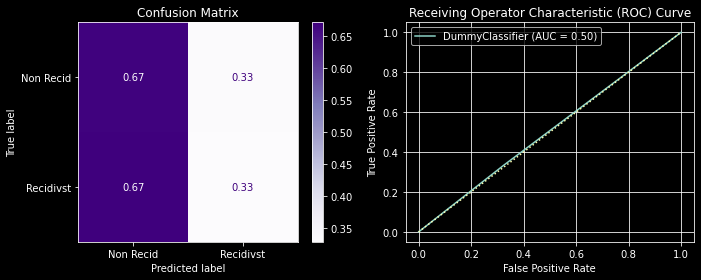

In [44]:
from sklearn.dummy import DummyClassifier
dummy= DummyClassifier(strategy='stratified')
dummy.fit(X_train_tf,y_train)
evaluate_classification(dummy,X_test_tf,y_test,
                       label='Dummy Classifier')

### Vanilla RandomForest

------------------------------------------------------------
[i] CLASSIFICATION REPORT:	Vanilla Random Forest
------------------------------------------------------------
              precision    recall  f1-score   support

   Non Recid       0.71      0.80      0.75      4335
   Recidivst       0.47      0.35      0.40      2170

    accuracy                           0.65      6505
   macro avg       0.59      0.57      0.58      6505
weighted avg       0.63      0.65      0.63      6505

------------------------------------------------------------




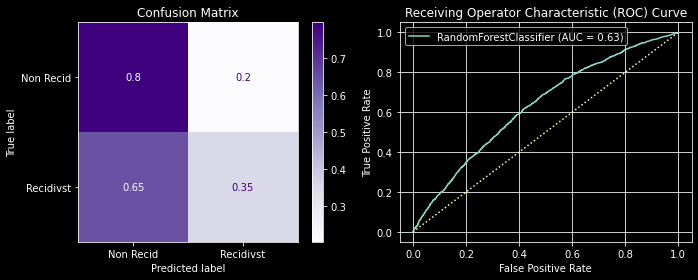

In [45]:
from sklearn.ensemble import RandomForestClassifier,StackingClassifier
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV

## 
clf = RandomForestClassifier()
clf.fit(X_train_tf,y_train)
evaluate_classification(clf,X_test_tf,y_test,label="Vanilla Random Forest")

In [46]:
def get_feature_importance(clf,X_train_tf,plot=True):
    importances = pd.Series(clf.feature_importances_,index=X_train_tf.columns)
    return importances.sort_values(ascending=False)

def plot_importance(clf,X_train_tf,n=25):
    importances = get_feature_importance(clf,X_train_tf)
    ax = importances.sort_values().tail(n).plot(kind='barh')#,figsize=figsize)
    ax.set(title=f"Top {n} Most Important Features",xlabel='importance')

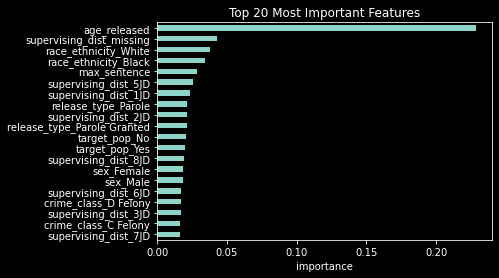

In [47]:
plot_importance(clf, X_test_tf,n=20)

### RandomForest - `class_weight="balanced"`

------------------------------------------------------------
[i] CLASSIFICATION REPORT:	Random Forest (class_weight='balanced')
------------------------------------------------------------
              precision    recall  f1-score   support

   Non Recid       0.73      0.70      0.71      4335
   Recidivst       0.44      0.48      0.46      2170

    accuracy                           0.62      6505
   macro avg       0.58      0.59      0.59      6505
weighted avg       0.63      0.62      0.63      6505

------------------------------------------------------------




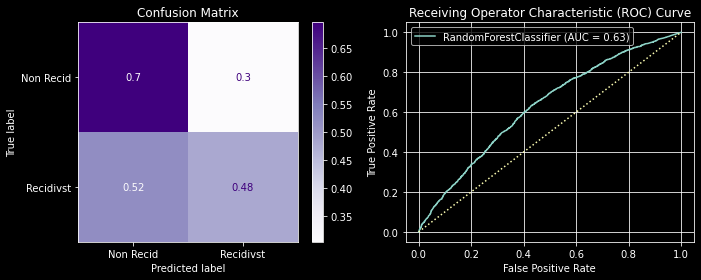

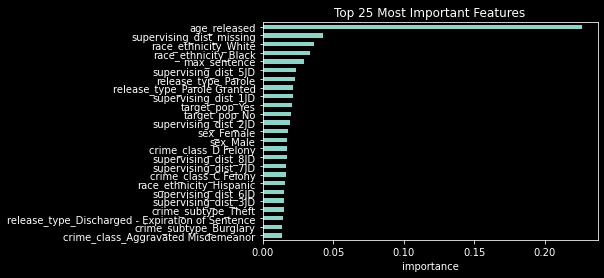

In [48]:
clf = RandomForestClassifier(class_weight='balanced')
clf.fit(X_train_tf,y_train)
evaluate_classification(clf,X_test_tf,y_test,label= "Random Forest (class_weight='balanced')")
plot_importance(clf,X_test_tf)

In [49]:
# get_feature_importance(clf,X_test_tf).to_frame('importance').style.bar()

### SMOTENC

In [50]:
## Getting cat features index
cat_col_index = [False for col in num_cols]
cat_col_index.extend([True for col in cat_features])
cat_col_index[:5]

[False, False, True, True, True]

In [51]:
from imblearn.over_sampling import SMOTENC
smote = SMOTENC(cat_col_index,n_jobs=-1)

In [52]:
X_train_smote,y_train_smote = smote.fit_resample(X_train_tf,y_train)
y_train_smote.value_counts()

1    13004
0    13004
Name: recidivist, dtype: int64

In [53]:
X_train_smote[:5]

,age_released,max_sentence,supervising_dist_1JD,supervising_dist_2JD,supervising_dist_3JD,supervising_dist_4JD,supervising_dist_5JD,supervising_dist_6JD,supervising_dist_7JD,supervising_dist_8JD,supervising_dist_ISC,supervising_dist_Interstate Compact,supervising_dist_missing,release_type_Discharged - Expiration of Sentence,release_type_Discharged – End of Sentence,release_type_Parole,release_type_Parole Granted,release_type_Paroled to Detainer - INS,release_type_Paroled to Detainer - Iowa,release_type_Paroled to Detainer - Out of State,release_type_Paroled to Detainer - U.S. Marshall,release_type_Paroled w/Immediate Discharge,release_type_Released to Special Sentence,release_type_Special Sentence,release_type_missing,race_ethnicity_American Native,race_ethnicity_Asian or Pacific Islander,race_ethnicity_Black,race_ethnicity_Hispanic,race_ethnicity_White,race_ethnicity_missing,sex_Female,sex_Male,sex_missing,crime_class_A Felony,crime_class_Aggravated Misdemeanor,crime_class_B Felony,crime_class_C Felony,crime_class_D Felony,crime_class_Felony - Enhanced,crime_class_Other Felony,crime_class_Other Misdemeanor,crime_class_Serious Misdemeanor,crime_class_Sex Offender,crime_class_Simple Misdemeanor,crime_type_Drug,crime_type_Other,crime_type_Property,crime_type_Public Order,crime_type_Violent,crime_subtype_Alcohol,crime_subtype_Animals,crime_subtype_Arson,crime_subtype_Assault,crime_subtype_Burglary,crime_subtype_Drug Possession,crime_subtype_Flight/Escape,crime_subtype_Forgery/Fraud,crime_subtype_Kidnap,crime_subtype_Murder/Manslaughter,crime_subtype_OWI,crime_subtype_Other Criminal,crime_subtype_Other Drug,crime_subtype_Other Public Order,crime_subtype_Other Violent,crime_subtype_Prostitution/Pimping,crime_subtype_Robbery,crime_subtype_Sex,crime_subtype_Sex Offender Registry/Residency,crime_subtype_Special Sentence Revocation,crime_subtype_Stolen Property,crime_subtype_Theft,crime_subtype_Traffic,crime_subtype_Trafficking,crime_subtype_Vandalism,crime_subtype_Weapons,target_pop_No,target_pop_Yes
0,0.320945,0.083185,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,-0.485239,0.083185,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,-1.291424,3.604288,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-0.485239,-0.356953,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.320945,-0.356953,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


### RandomForest with SMOTE

------------------------------------------------------------
[i] CLASSIFICATION REPORT:	RandomForest - SMOTE
------------------------------------------------------------
              precision    recall  f1-score   support

   Non Recid       0.73      0.67      0.70      4335
   Recidivst       0.43      0.49      0.46      2170

    accuracy                           0.61      6505
   macro avg       0.58      0.58      0.58      6505
weighted avg       0.63      0.61      0.62      6505

------------------------------------------------------------




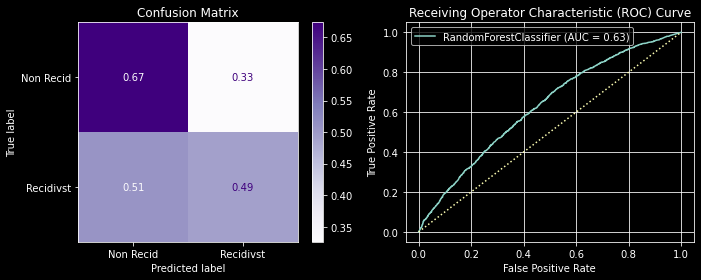

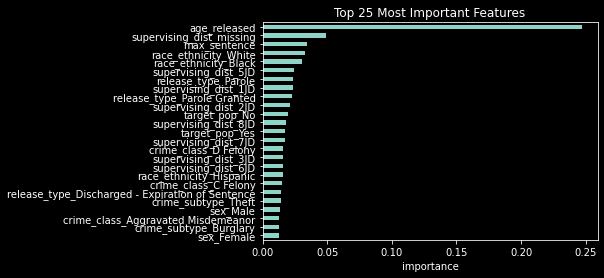

In [54]:
clf = RandomForestClassifier()#class_weight='balanced')
clf.fit(X_train_smote,y_train_smote)
evaluate_classification(clf,X_test_tf,y_test,label='RandomForest - SMOTE')
plot_importance(clf,X_test_tf)

# GridSearch RF

{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 2}
0.6957512051577794
------------------------------------------------------------
[i] CLASSIFICATION REPORT
------------------------------------------------------------
              precision    recall  f1-score   support

   Non Recid       0.75      0.67      0.71      4335
   Recidivst       0.45      0.55      0.50      2170

    accuracy                           0.63      6505
   macro avg       0.60      0.61      0.60      6505
weighted avg       0.65      0.63      0.64      6505

------------------------------------------------------------




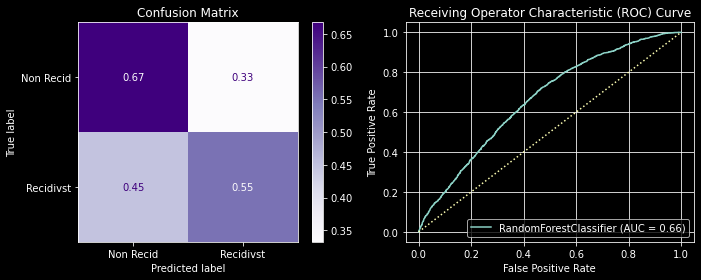

In [55]:
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV

clf = RandomForestClassifier()
params ={'max_depth':[None,5,7,10,20,30,],
         'min_samples_leaf':[1,2,3],
         'criterion':['gini','entropy'],        
        }


grid = GridSearchCV(clf,params,scoring='recall_macro', n_jobs=-1)

grid.fit(X_train_smote,y_train_smote)
print(grid.best_params_)

print(grid.best_score_)
evaluate_classification(grid.best_estimator_,X_test_tf,y_test)

In [56]:
# scores =['recall','recall_macro','accuracy']
GRIDS={}

[i] Starting f1
For scoring=f1:
{'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 1}



------------------------------------------------------------
[i] CLASSIFICATION REPORT:	f1
------------------------------------------------------------
              precision    recall  f1-score   support

   Non Recid       0.75      0.64      0.69      4335
   Recidivst       0.45      0.58      0.50      2170

    accuracy                           0.62      6505
   macro avg       0.60      0.61      0.60      6505
weighted avg       0.65      0.62      0.63      6505

------------------------------------------------------------




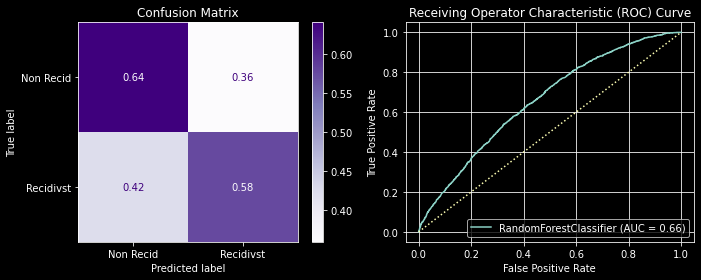

[i] Starting f1_macro
For scoring=f1_macro:
{'criterion': 'entropy', 'max_depth': 30, 'min_samples_leaf': 1}



------------------------------------------------------------
[i] CLASSIFICATION REPORT:	f1_macro
------------------------------------------------------------
              precision    recall  f1-score   support

   Non Recid       0.73      0.67      0.70      4335
   Recidivst       0.43      0.50      0.46      2170

    accuracy                           0.62      6505
   macro avg       0.58      0.59      0.58      6505
weighted avg       0.63      0.62      0.62      6505

------------------------------------------------------------




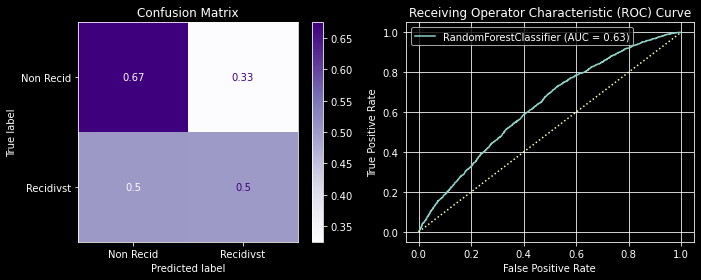

[i] Starting roc_auc
For scoring=roc_auc:
{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 2}



------------------------------------------------------------
[i] CLASSIFICATION REPORT:	roc_auc
------------------------------------------------------------
              precision    recall  f1-score   support

   Non Recid       0.75      0.67      0.70      4335
   Recidivst       0.45      0.54      0.49      2170

    accuracy                           0.63      6505
   macro avg       0.60      0.61      0.60      6505
weighted avg       0.65      0.63      0.63      6505

------------------------------------------------------------




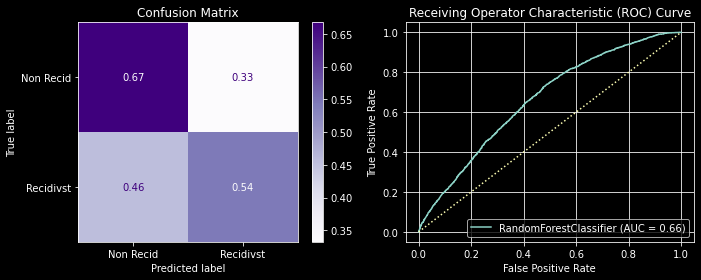

[i] Starting recall
For scoring=recall:
{'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 1}



------------------------------------------------------------
[i] CLASSIFICATION REPORT:	recall
------------------------------------------------------------
              precision    recall  f1-score   support

   Non Recid       0.75      0.64      0.69      4335
   Recidivst       0.44      0.58      0.50      2170

    accuracy                           0.62      6505
   macro avg       0.60      0.61      0.60      6505
weighted avg       0.65      0.62      0.63      6505

------------------------------------------------------------




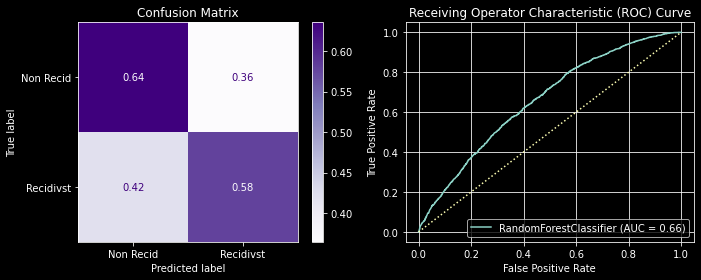

[i] Starting recall_macro
For scoring=recall_macro:
{'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 1}



------------------------------------------------------------
[i] CLASSIFICATION REPORT:	recall_macro
------------------------------------------------------------
              precision    recall  f1-score   support

   Non Recid       0.75      0.64      0.69      4335
   Recidivst       0.44      0.58      0.50      2170

    accuracy                           0.62      6505
   macro avg       0.60      0.61      0.59      6505
weighted avg       0.65      0.62      0.62      6505

------------------------------------------------------------




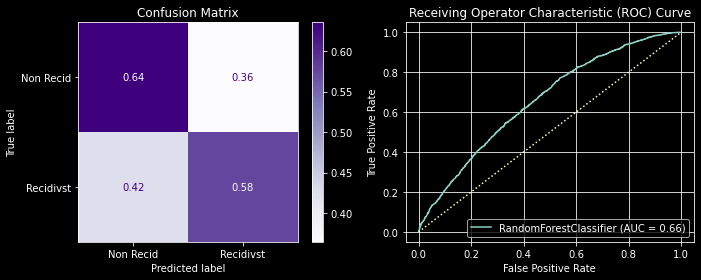

[i] Starting accuracy
For scoring=accuracy:
{'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 1}



------------------------------------------------------------
[i] CLASSIFICATION REPORT:	accuracy
------------------------------------------------------------
              precision    recall  f1-score   support

   Non Recid       0.75      0.63      0.69      4335
   Recidivst       0.44      0.58      0.50      2170

    accuracy                           0.62      6505
   macro avg       0.60      0.61      0.60      6505
weighted avg       0.65      0.62      0.63      6505

------------------------------------------------------------




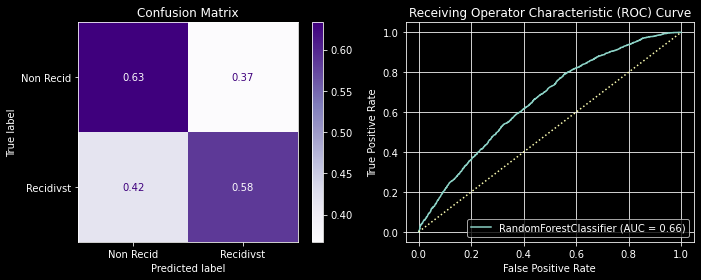

[i] Starting precision
For scoring=precision:
{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1}



------------------------------------------------------------
[i] CLASSIFICATION REPORT:	precision
------------------------------------------------------------
              precision    recall  f1-score   support

   Non Recid       0.73      0.68      0.70      4335
   Recidivst       0.43      0.49      0.46      2170

    accuracy                           0.62      6505
   macro avg       0.58      0.58      0.58      6505
weighted avg       0.63      0.62      0.62      6505

------------------------------------------------------------




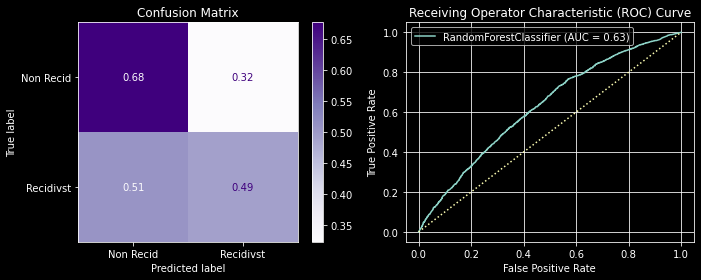

In [58]:
## Build loop to make dict of grids for each score method
scores =['f1','f1_macro','roc_auc','recall','recall_macro','accuracy','precision']

reports = {}
for score in scores:
    line = '==='*30
    print(line)
    print(f'[i] Starting {score}',end='\n'+line)
    
    GRIDS[score] = GridSearchCV(clf,params,cv=3,scoring=score, n_jobs=-1)
    GRIDS[score].fit(X_train_smote,y_train_smote)
    
    print(f"\nFor scoring={score}:" )
    print(GRIDS[score].best_params_)
    print('\n\n')
    
    reports[score] = evaluate_classification(GRIDS[score].best_estimator_,
                                    X_test_tf,y_test,label=score,return_report=True)
    ## Adding best_params to reports
#     reports[score]['best_params'] = GRIDS[score].best_params_

In [59]:
dfs=[]
for metric,result in reports.items():
    
    result['scoring_param'] = metric
    dfs.append(pd.DataFrame(result))
    
RESULTS = pd.concat(dfs).reset_index().set_index(['scoring_param','index'])
# RESULTS.drop('scoring param',inplace=True)
RESULTS

Non Recid  ...  best_params
scoring_param index                          ...             
f1            precision            0.751420  ...          NaN
              recall               0.640830  ...          NaN
              f1-score             0.691733  ...          NaN
              support           4335.000000  ...          NaN
              criterion                 NaN  ...         gini
              max_depth                 NaN  ...           20
              min_samples_leaf          NaN  ...            1
f1_macro      precision            0.729063  ...          NaN
              recall               0.674740  ...          NaN
              f1-score             0.700851  ...          NaN
              support           4335.000000  ...          NaN
              criterion                 NaN  ...      entropy
              max_depth                 NaN  ...           30
              min_samples_leaf          NaN  ...            1
roc_auc       precision            0.745300  ...          NaN
              recall               0.667589  ...          NaN
              f1-score             0.704308  ...          NaN
              support           4335.000000  ...          NaN
              criterion                 NaN  ...      entropy
              max_depth                 NaN  ...         None
              min_samples_leaf          NaN  ...            2
recall        precision            0.751158  ...          NaN
              recall               0.635755  ...          NaN
              f1-score             0.688656  ...          NaN
              support           4335.000000  ...          NaN
              criterion                 NaN  ...         gini
              max_depth                 NaN  ...           20
              min_samples_leaf          NaN  ...            1
recall_macro  precision            0.749388  ...          NaN
              recall               0.635294  ...          NaN
              f1-score             0.687640  ...          NaN
              support           4335.000000  ...          NaN
              criterion                 NaN  ...         gini
              max_depth                 NaN  ...           20
              min_samples_leaf          NaN  ...            1
accuracy      precision            0.752606  ...          NaN
              recall               0.632987  ...          NaN
              f1-score             0.687633  ...          NaN
              support           4335.000000  ...          NaN
              criterion                 NaN  ...         gini
              max_depth                 NaN  ...           20
              min_samples_leaf          NaN  ...            1
precision     precision            0.727138  ...          NaN
              recall               0.676817  ...          NaN
              f1-score             0.701075  ...          NaN
              support           4335.000000  ...          NaN
              criterion                 NaN  ...      entropy
              max_depth                 NaN  ...         None
              min_samples_leaf          NaN  ...            1

[49 rows x 6 columns]

# BOOKMARK 10/03 7;40PM

# LogisticRegression

In [ ]:
X_train_smote.describe()

In [ ]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# X_train_logreg = scaler.fit_transform(X_train_smote)
# X_test_logreg = scaler.transform(X_test_tf)

In [ ]:
logregCV = LogisticRegressionCV(scoring='recall',penalty='l1',cv=3,
                                solver='liblinear',max_iter=250,n_jobs=-1)

logregCV.fit(X_train_smote,y_train_smote)
logregCV

In [ ]:
evaluate_classification(logregCV,X_test_tf,y_test)

In [ ]:
def get_coeffs(logregCV, X_train_smote,):
    coeffs = pd.Series(logregCV.coef_[0],index=X_train_smote.columns)
    coeffs['Intercept'] = logregCV.intercept_
    coeffs = coeffs.astype(float)
    return coeffs

coeffs = get_coeffs(logregCV,X_train_smote)
coeffs.sort_values().plot(kind='barh',figsize=(5,10))

In [ ]:
# logregCV.C_, logregCV.

## TO DO: Try tune-sklearn
- [Blog Post](https://towardsdatascience.com/5x-faster-scikit-learn-parameter-tuning-in-5-lines-of-code-be6bdd21833c)
- [Documentation](https://github.com/ray-project/tune-sklearn)

## StackingClassifier

In [ ]:
from sklearn.ensemble import StackingClassifier

stack = StackingClassifier(estimators=[
    ('rf',)
])

# CONCLUSIONS
- **After adjusting for imbalanced classes, the most important factor for determining recidivism are:**
    - **Age at Release**
    - **Supervising Judicial District**
    - **Release Type**
    - **Crime Subtype**
    
    
## Recommendatons
- This model could be used to predict which prisoners due for release may at the greatest risk for recidivism.<br><br>
    - Using this knowledge, the state of Iowa could put new programs into action that target those at high risk for recidivism and provide additional assistance and guidance following release.<br><br>
    - Additionally, there could be additional counseling or education _prior_ to release to supply the inmate with tools and options to avoid returning to a life of crime.
    
# FUTURE DIRECTIONS
- With more time and reliable performance, would perform cross-validation of our final model.<br><br>
- Additional visuals summarizing the underlying features effects on recidivism.<br><br>
- Adapting more available visualization tools to better display the underpinning of the model.
<br><br>
- Exploration of the predictability of crimes types committed by recidivists.

### POST-REVIEW SUGGESTIONS / IDEAS:
- [ ] Try using reduction instead of SMOTE.
- [ ] seaborn catplot bar graphs
- [ ] Add tree or other visuals
    - Try Mike's SHAP plots

# APPENDIX

In [ ]:
STOP

In [ ]:
from bs_ds import viz_tree

In [ ]:
viz_tree(cb_clf)

In [ ]:
compare_tree = sklearn.tree.DecisionTreeClassifier()
dir(compare_tree)

In [ ]:
compare_tree.fit(X_train, y_train)

In [ ]:
dir(compare_tree)

In [ ]:
# This is the tree object that sklearn generates and is looking for 
help(compare_tree.tree_)

In [ ]:
dir(cb_clf)

In [ ]:
help(cb_clf.get_metadata())

In [ ]:
test = cb_clf.get_metadata()

In [ ]:
help(cb_clf)

### SHAP values
https://github.com/jirvingphd/shap


In [ ]:
import shap
shap.initjs()

In [ ]:
explainer = shap.TreeExplainer(cb_clf)

In [ ]:
shap_vals = explainer.shap_values(train_pool)

In [ ]:
shap.force_plot(explainer.expected_value, shap_vals[:1000],X_train[:1000])

In [ ]:
shap.summary_plot(shap_vals, X_train)

In [ ]:
shap.summary_plot(shap_vals, X_train, plot_type="bar")